In [3]:
import pandas as pd # pannel datasets
import numpy as np
import matplotlib.pyplot as plt 
import datetime
import itertools
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.stattools import adfuller
from scipy import stats
from statsmodels.tsa.statespace.sarimax import SARIMAX
from calendar import monthrange, month_name
from tqdm.notebook import tqdm
import seaborn as sns
import numpy as np
import pylab
import scipy.stats as stats
import statsmodels.api as sm
from tqdm import tqdm_notebook

In [4]:
# load the data using pandas
df = pd.read_excel('./Data/QualidadeARO3.xlsx', sheet_name='Sheet1', engine="openpyxl")

In [5]:
#df.head()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8784 entries, 0 to 8783
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Antas-Espinho      8784 non-null   float64
 1   Entrecampos        8784 non-null   float64
 2   Estarreja          8784 non-null   float64
 3   Ihavo              8784 non-null   float64
 4   Laranjeiro-Almada  8784 non-null   float64
 5   Mem-Martins        8784 non-null   float64
 6   Paio-Pires         8784 non-null   float64
 7   Restelo            8784 non-null   float64
 8   Sobreiras-Porto    8784 non-null   float64
 9   VNTelha-Maia       8784 non-null   int64  
dtypes: float64(9), int64(1)
memory usage: 686.4 KB


In [6]:
# Calculate month range borders (we need that later)
year = 2000
days = 0
ranges = []
for i in range(12):
    start = days
    days += monthrange(year, i+1)[1] * 24
    end = days
    ranges.append((start,end))
month_cuts = [x[1] for x in ranges]

0 0
0 1
0 2
1 0
1 1
1 2
2 0
2 1
2 2
('Estarreja', 37.13734472310293, 26.04513225589056)
('Antas-Espinho', 41.91886149009665, 21.365148008704868)
('Sobreiras-Porto', 50.92896174863388, 28.615851897398933)
('Entrecampos', 52.69962431693989, 27.363527127874548)
('Paio-Pires', 52.986190699772756, 25.68408034059013)
('Restelo', 53.59471222354255, 24.64105431106354)
('Laranjeiro-Almada', 56.73644042274474, 26.92704391936502)
('Ihavo', 57.31659836065574, 27.259929287552925)
('Mem-Martins', 66.42042349726776, 24.034454452089598)


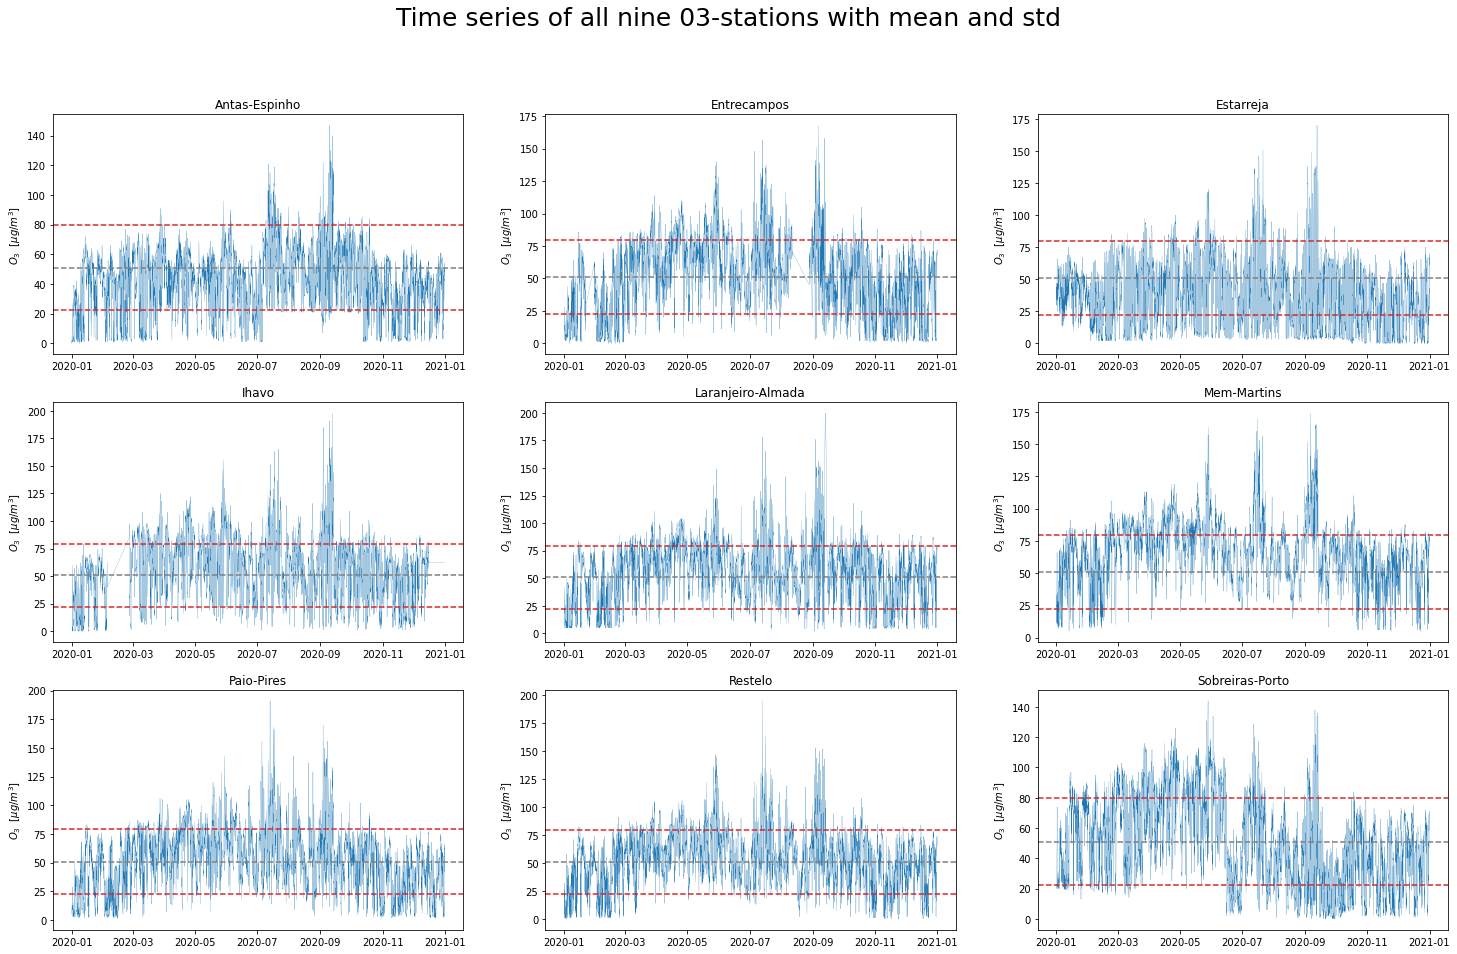

In [7]:
# Divide the series into subseries
names = df.columns
series = [df[name] for name in names]

# Time span
dates = pd.date_range("2020-01-01", periods=len(df), freq="H")

# Time plots of all nine series for an initial look
n1, m2 = 3, 3
amount_series = range(n1*m2)
y_label = '$O_3$  $[\mu g/m^3]$'

data = []
for i in amount_series:
    mean, std = series[i].mean(), series[i].std()
    data.append((names[i], mean, std))
data.sort(key=lambda x: x[1])

fig1, axs1 = plt.subplots(n1, m2, figsize=(25,15))
fig1.suptitle(f"Time series of all nine 03-stations with mean and std", fontsize=25)

for i,_ in enumerate(data):
    x, y = int(i/n1), i%n1
    print(x,y)
    axs1[x, y].plot_date(dates, series[i], fmt="-", linewidth=0.2)#colors[x])
    axs1[x, y].set_ylabel(y_label)
    axs1[x, y].set_title(names[i])
    axs1[x, y].axhline(y=mean, color='tab:gray', linestyle='--')
    axs1[x, y].axhline(y=mean+std, color='tab:red', linestyle='--')
    axs1[x, y].axhline(y=mean-std, color='tab:red', linestyle='--')

print(*data, sep="\n")

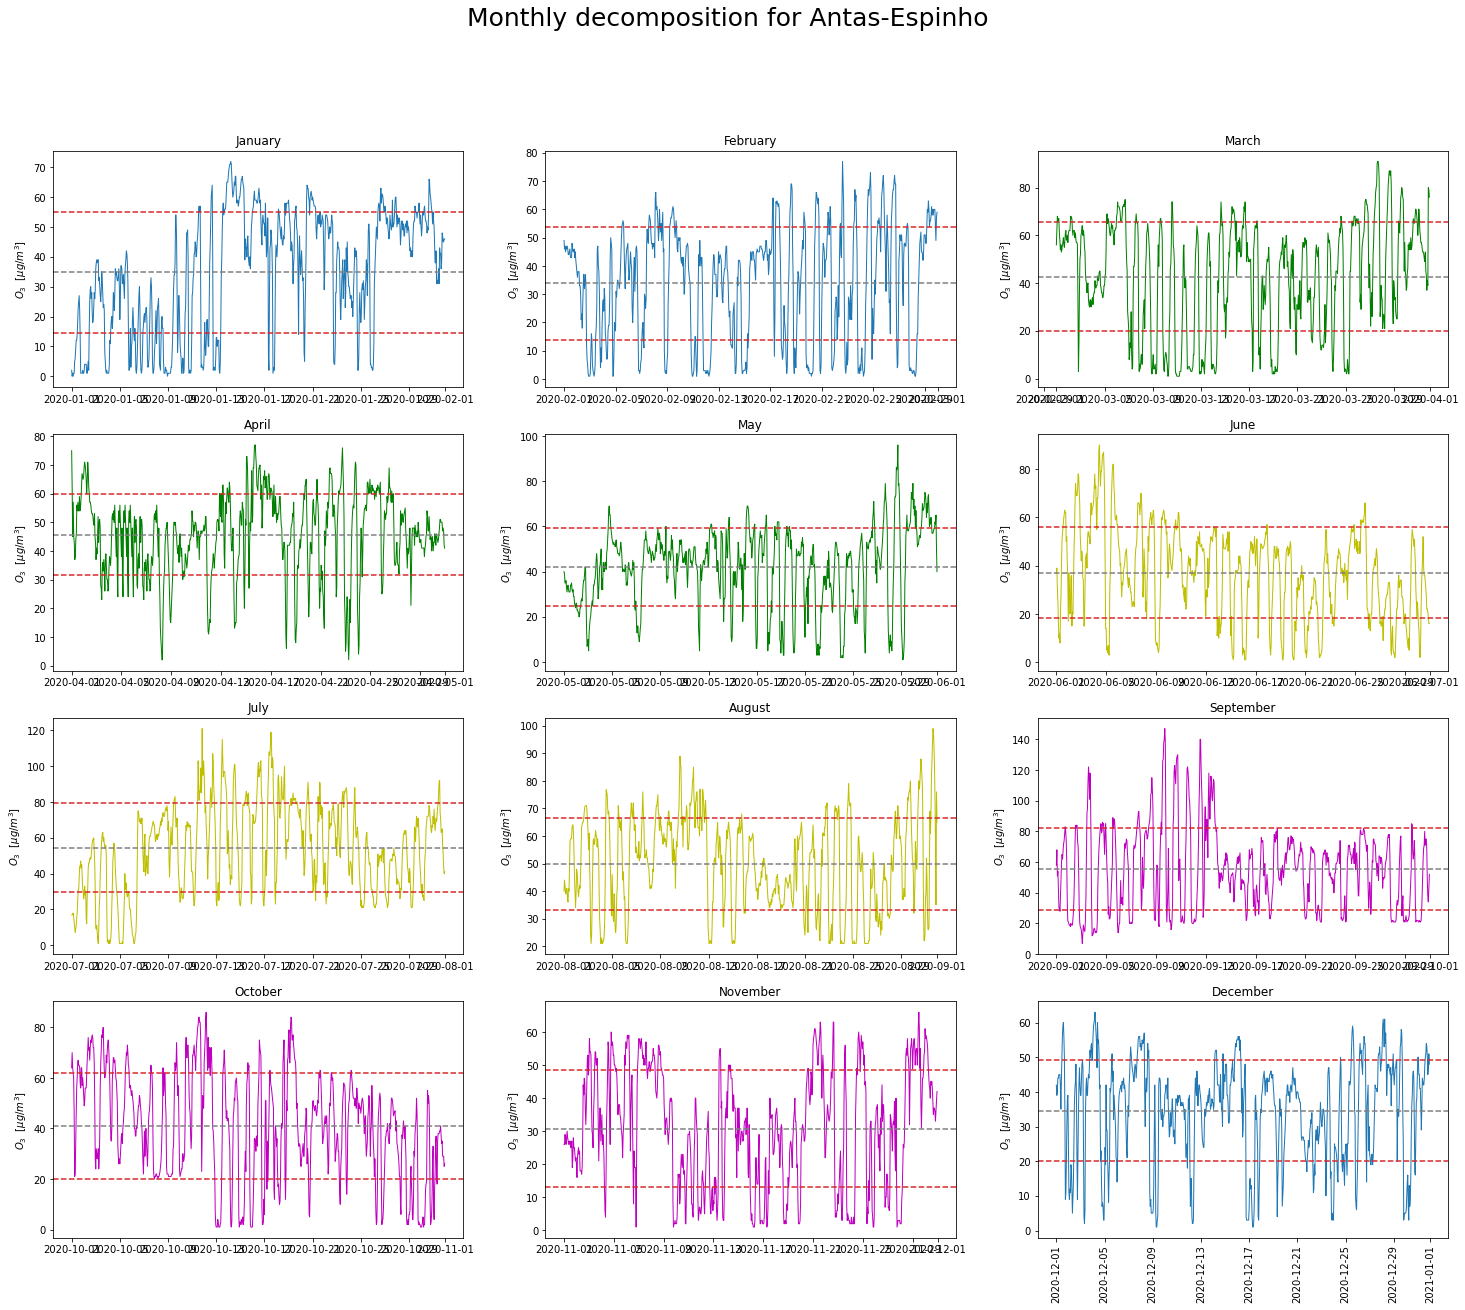

In [8]:
# Analyzing month by month
colors = ["-", "-", "g-","g-","g-", "y-","y-","y-", "m-","m-","m-", "-",]
number = 0
current_series = series[number]
n2, m2, months = 4, 3, 12
days = 0
fig2, axs2 = plt.subplots(n2, m2, figsize=(25,20))
fig2.suptitle(f"Monthly decomposition for {names[number]}", fontsize=25)
data = []
for i, (start, end) in enumerate(ranges):
    x, y = int(i/m2), i%m2
    month_series = current_series[start:end]
    month_dates = dates[start:end]
    mean, std = month_series.mean(), month_series.std()
    axs2[x, y].plot_date(month_dates, month_series, fmt=colors[i], linewidth=1)
    axs2[x, y].set_ylabel(y_label)
    axs2[x, y].set_title(datetime.date(2000, i+1, 1).strftime('%B'))
    axs2[x, y].axhline(y=mean, color='tab:gray', linestyle='--')
    axs2[x, y].axhline(y=mean + std, color='tab:red', linestyle='--')
    axs2[x, y].axhline(y=mean - std, color='tab:red', linestyle='--')
    plt.xticks(rotation=90)

In [9]:
#Dickey fuller test

for i in range(len(names)):
    adf, pval, usedlag, nobs, crit_vals, icbest =  adfuller(series[i].values, regression="ct")
    print(names[i],'test statistic:', adf, 'ADF p-values:', pval)
#print('ADF number of lags used:', usedlag)
#print('ADF number of observations:', nobs)
#print('ADF critical values:', crit_vals)
#print('ADF best information criterion:', icbest)


Antas-Espinho test statistic: -9.599152179217752 ADF p-values: 1.6838982293795815e-14
Entrecampos test statistic: -7.351815283032942 ADF p-values: 2.231269649431546e-09
Estarreja test statistic: -10.610973127125858 ADF p-values: 1.2741905555763678e-16
Ihavo test statistic: -8.818345054405114 ADF p-values: 9.375096898768778e-13
Laranjeiro-Almada test statistic: -9.27702893223806 ADF p-values: 8.664035385441669e-14
Mem-Martins test statistic: -7.864615310523142 ADF p-values: 1.4689317183617558e-10
Paio-Pires test statistic: -8.156319632906786 ADF p-values: 3.109497012699794e-11
Restelo test statistic: -8.109800956839011 ADF p-values: 3.982745345674605e-11
Sobreiras-Porto test statistic: -7.852584167733166 ADF p-values: 1.566067659188926e-10
VNTelha-Maia test statistic: -10.272805555775784 ADF p-values: 6.194594611257754e-16


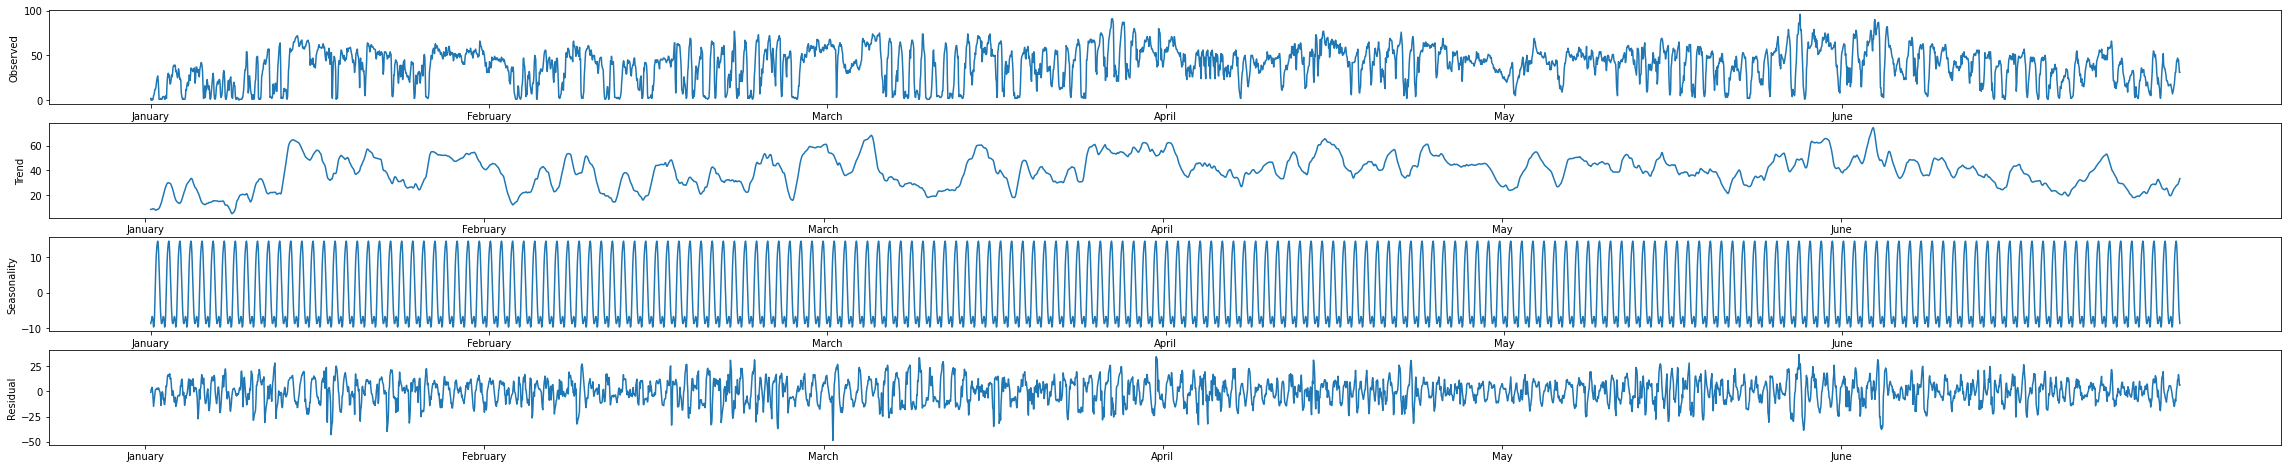

In [10]:
#Trends and seasonality
k = 2
result = seasonal_decompose(series[0], model='additive', period = 24)
fig, (ax1,ax2,ax3,ax4) = plt.subplots(4,1, figsize=(40,8))
n = int(len(current_series)/k)
current_series[:n].plot(ax=ax1)
ax1.set_ylabel('Observed')
result.trend[:n].plot(ax=ax2)
ax2.set_ylabel('Trend')
result.seasonal[:n].plot(ax=ax3)
ax3.set_ylabel('Seasonality')
result.resid[:n].plot(ax=ax4)
ax4.set_ylabel('Residual')
for i in range(1,5):
    eval(f"ax{i}").set_xticks([i*int(n/(12/k)) for i in range(int(12/k))], minor=False)
    eval(f"ax{i}").set_xticklabels(month_name[1:int(12/k)+1], fontdict=None, minor=False)

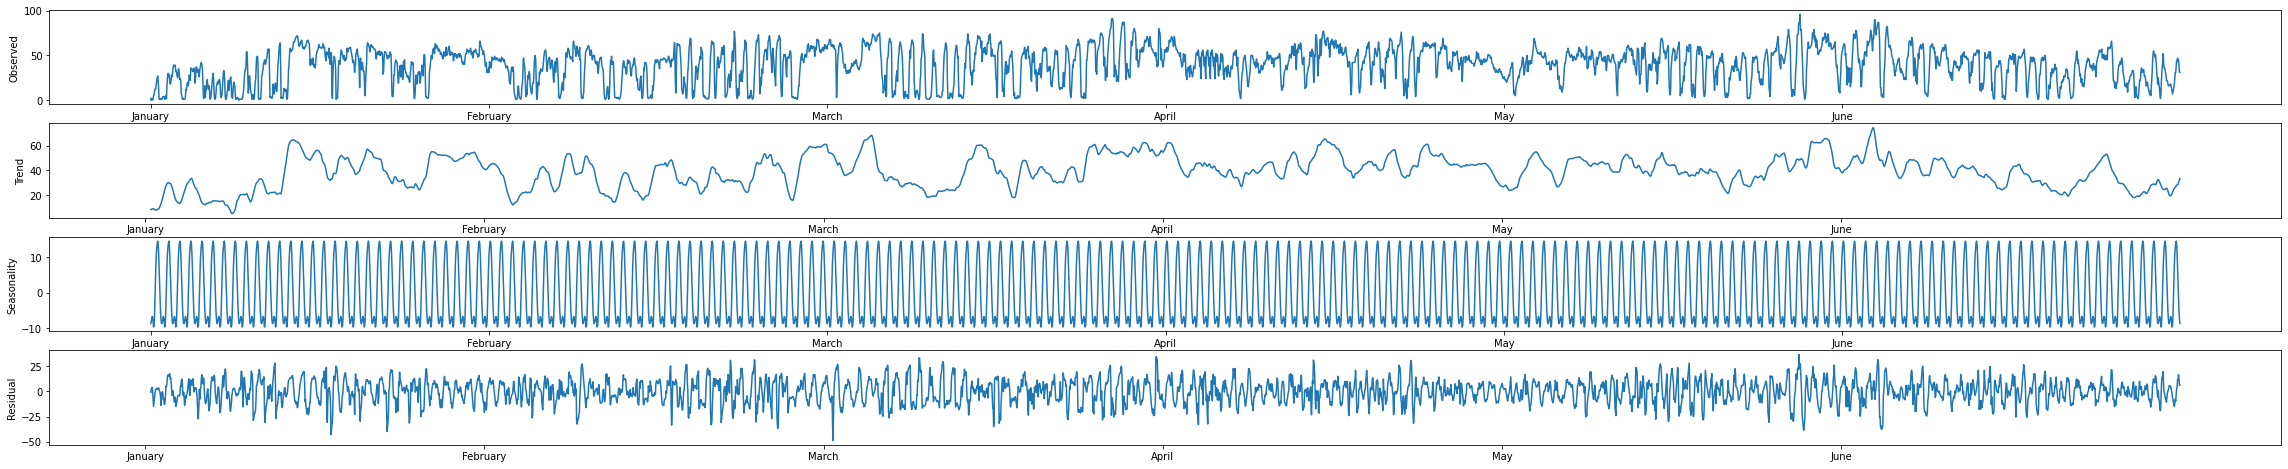

In [11]:
s = pd.Series([x+0.0001 for x in series[0]])
result = seasonal_decompose(s, model='a', period = 24)
fig, (ax1,ax2,ax3,ax4) = plt.subplots(4,1, figsize=(40,8))
n = int(len(current_series)/k)
current_series[:n].plot(ax=ax1)
ax1.set_ylabel('Observed')
result.trend[:n].plot(ax=ax2)
ax2.set_ylabel('Trend')
result.seasonal[:n].plot(ax=ax3)
ax3.set_ylabel('Seasonality')
result.resid[:n].plot(ax=ax4)
ax4.set_ylabel('Residual')
for i in range(1,5):
    eval(f"ax{i}").set_xticks([i*int(n/(12/k)) for i in range(int(12/k))], minor=False)
    eval(f"ax{i}").set_xticklabels(month_name[1:int(12/k)+1], fontdict=None, minor=False)

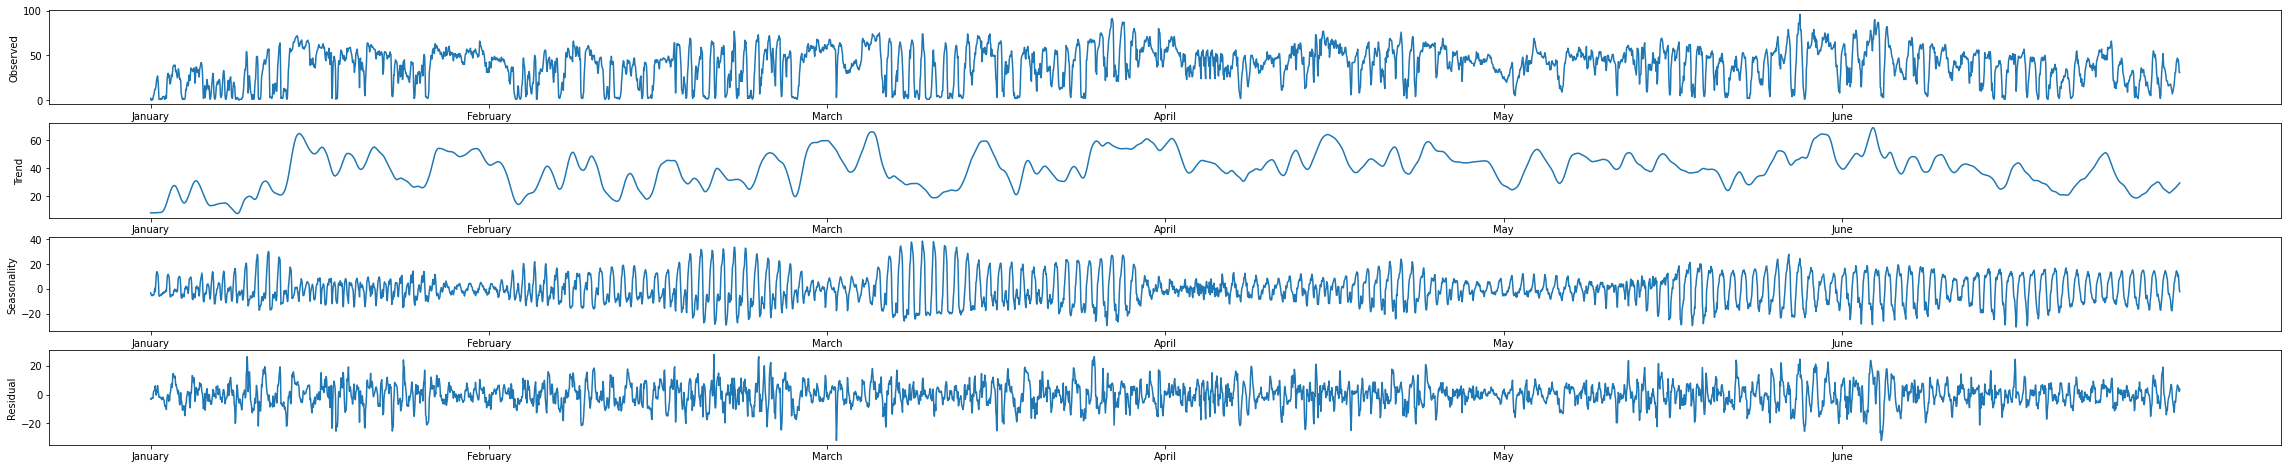

In [12]:
from statsmodels.tsa.seasonal import STL
result = STL(endog=series[0][:int(len(current_series)/k)], period=24).fit()
fig, (ax1,ax2,ax3,ax4) = plt.subplots(4,1, figsize=(40,8))
n = int(len(current_series)/k)
current_series[:n].plot(ax=ax1)
ax1.set_ylabel('Observed')
result.trend[:n].plot(ax=ax2)
ax2.set_ylabel('Trend')
result.seasonal[:n].plot(ax=ax3)
ax3.set_ylabel('Seasonality')
result.resid[:n].plot(ax=ax4)
ax4.set_ylabel('Residual')
for i in range(1,5):
    eval(f"ax{i}").set_xticks([i*int(n/(12/k)) for i in range(int(12/k))], minor=False)
    eval(f"ax{i}").set_xticklabels(month_name[1:int(12/k)+1], fontdict=None, minor=False)

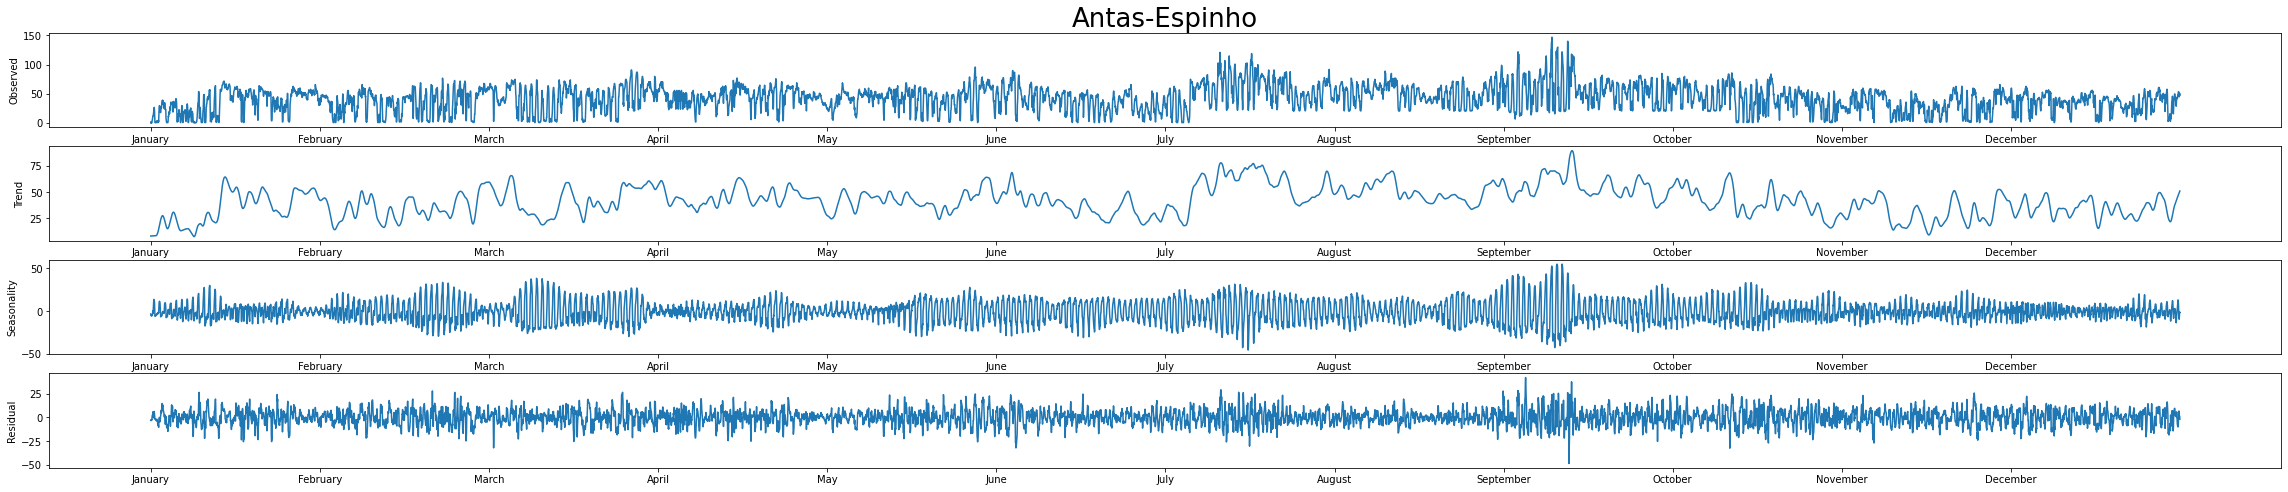

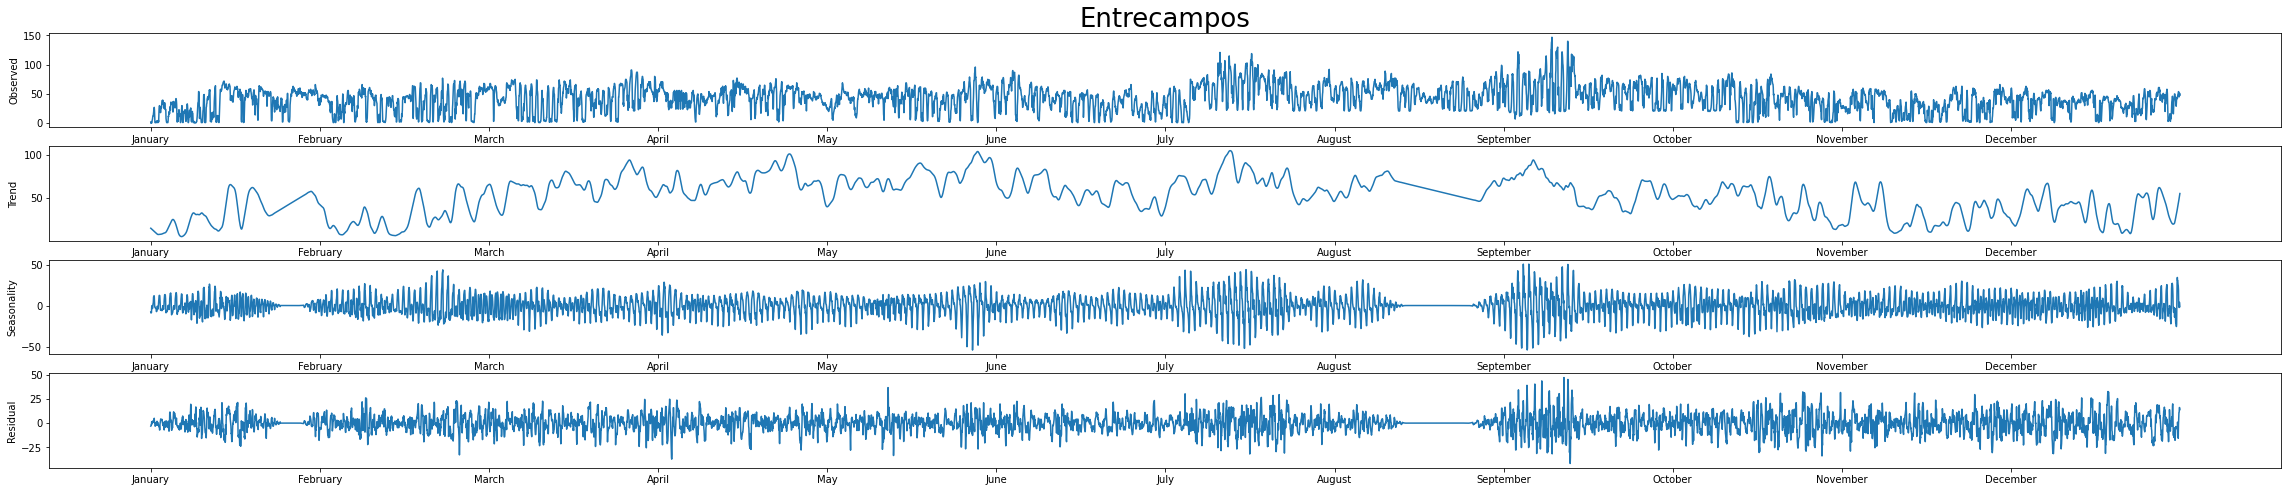

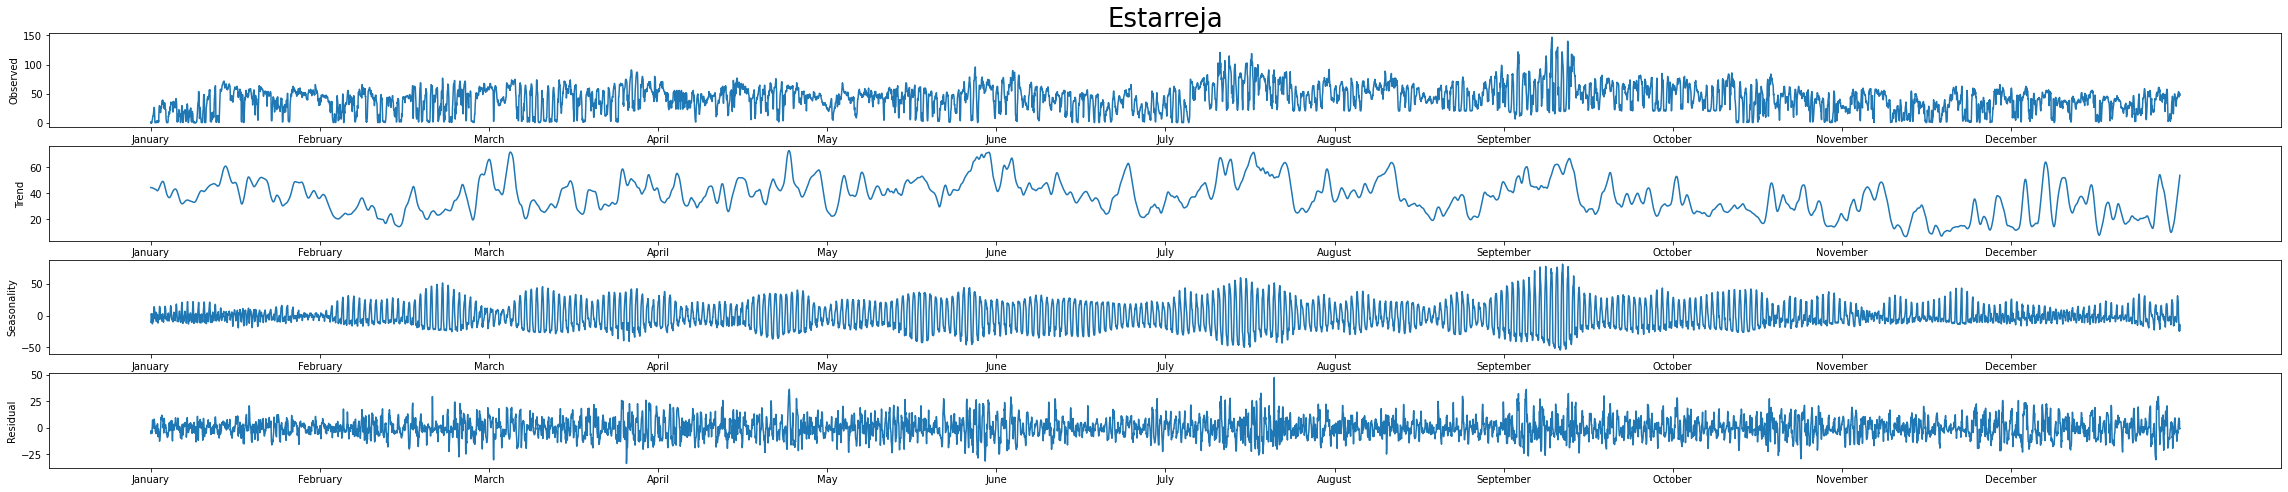

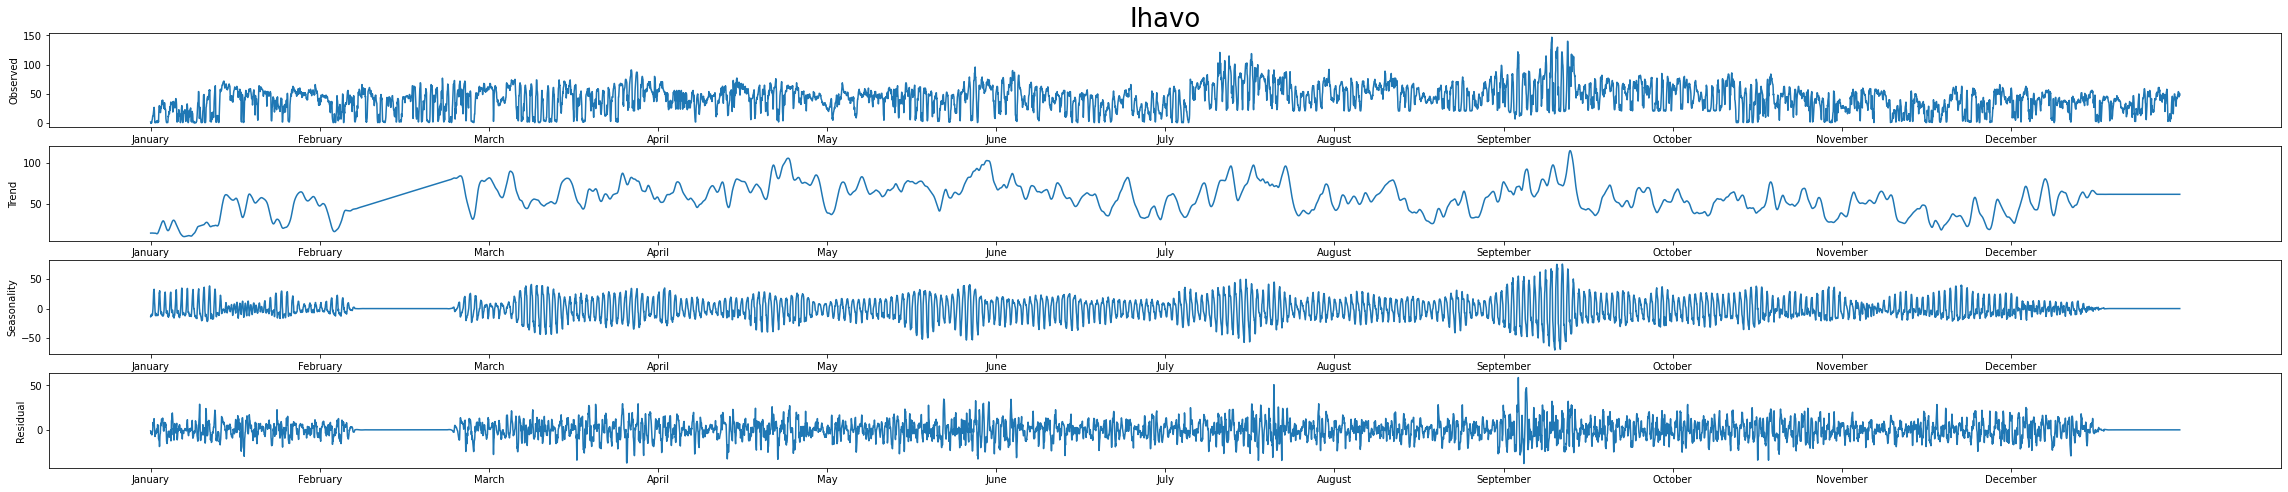

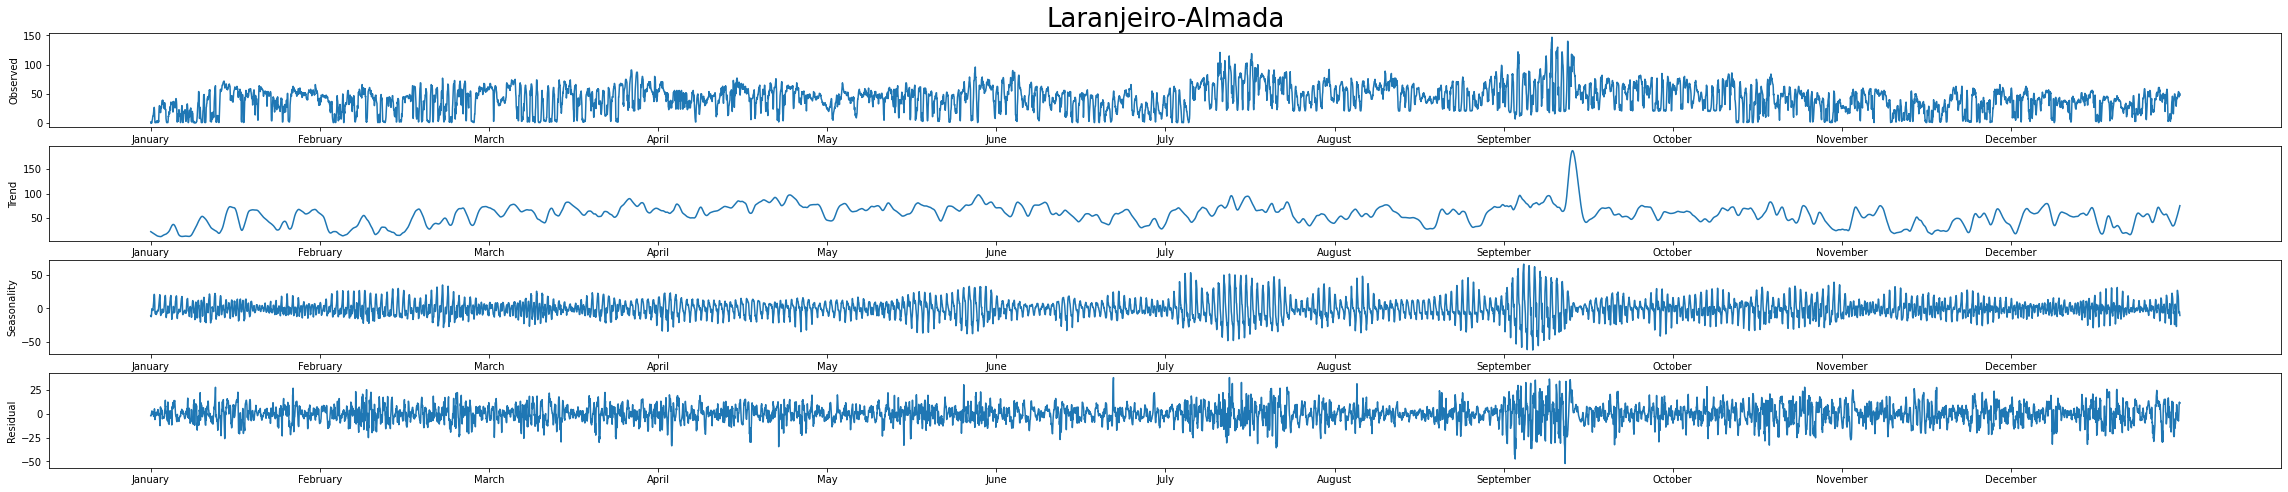

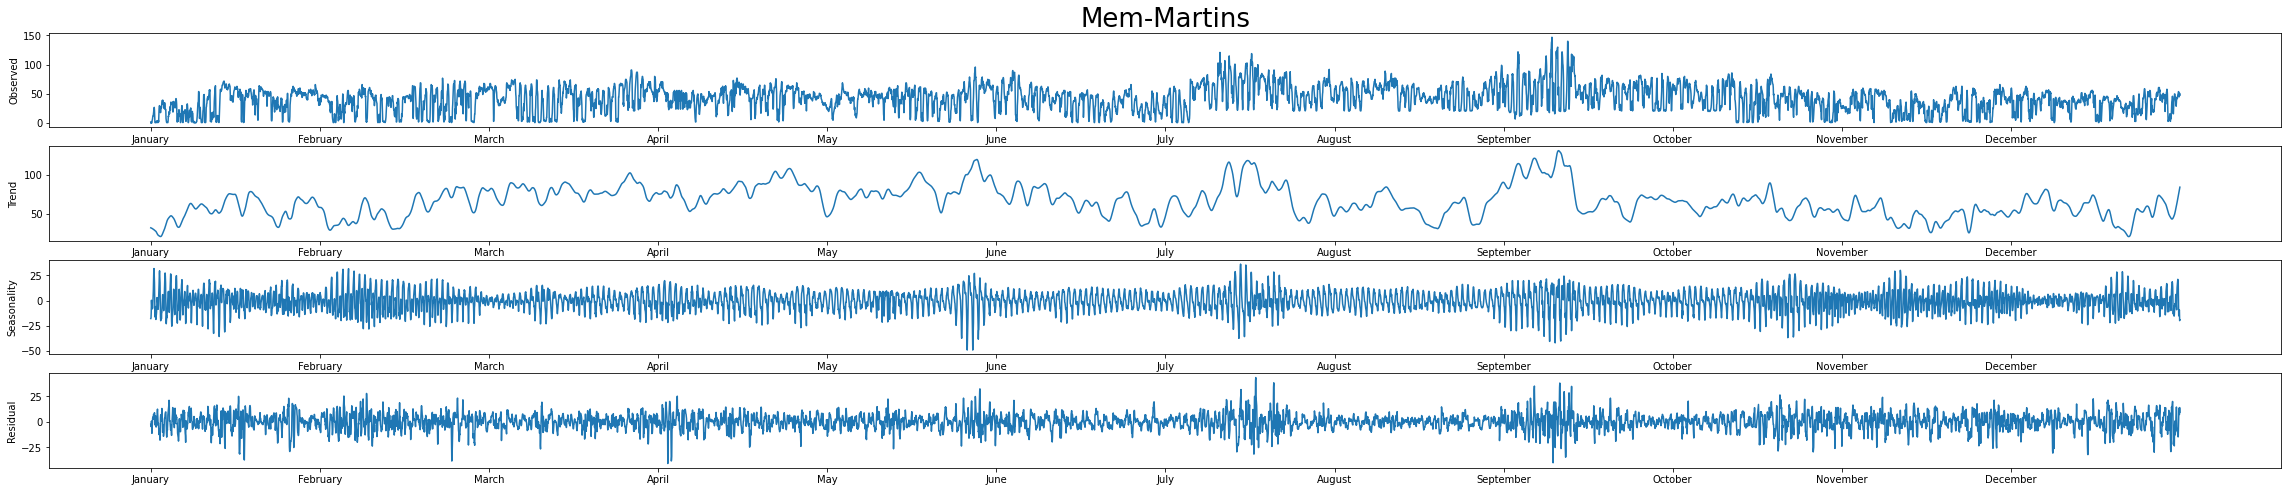

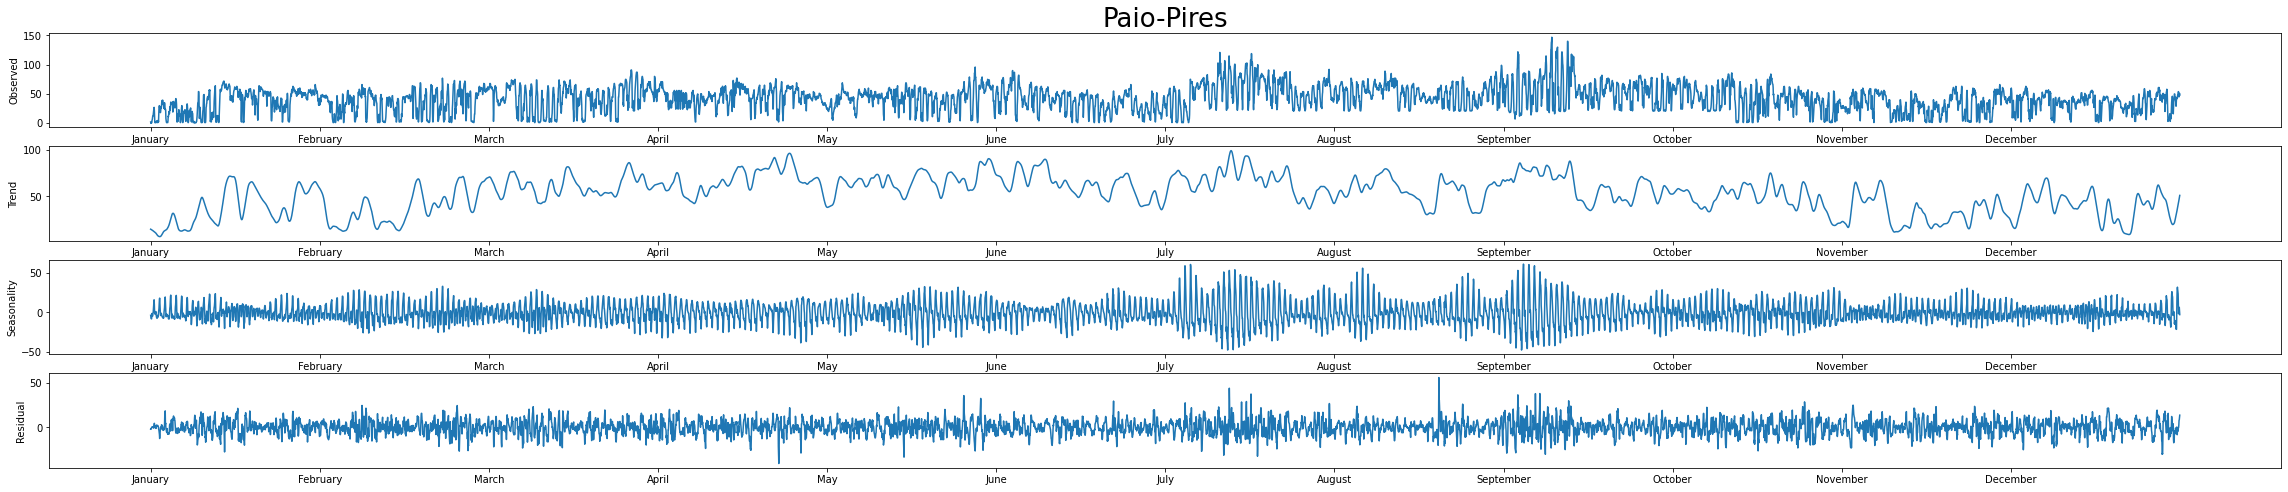

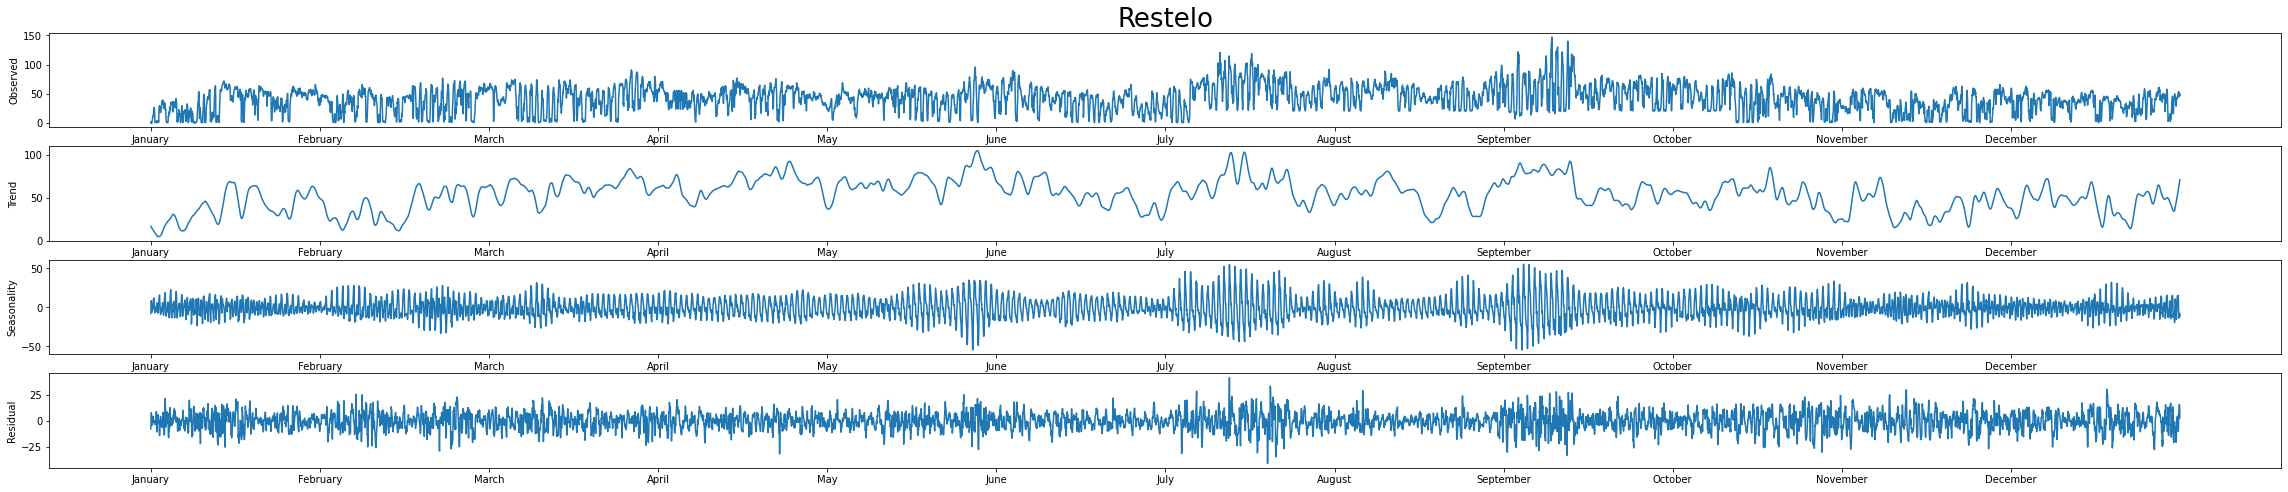

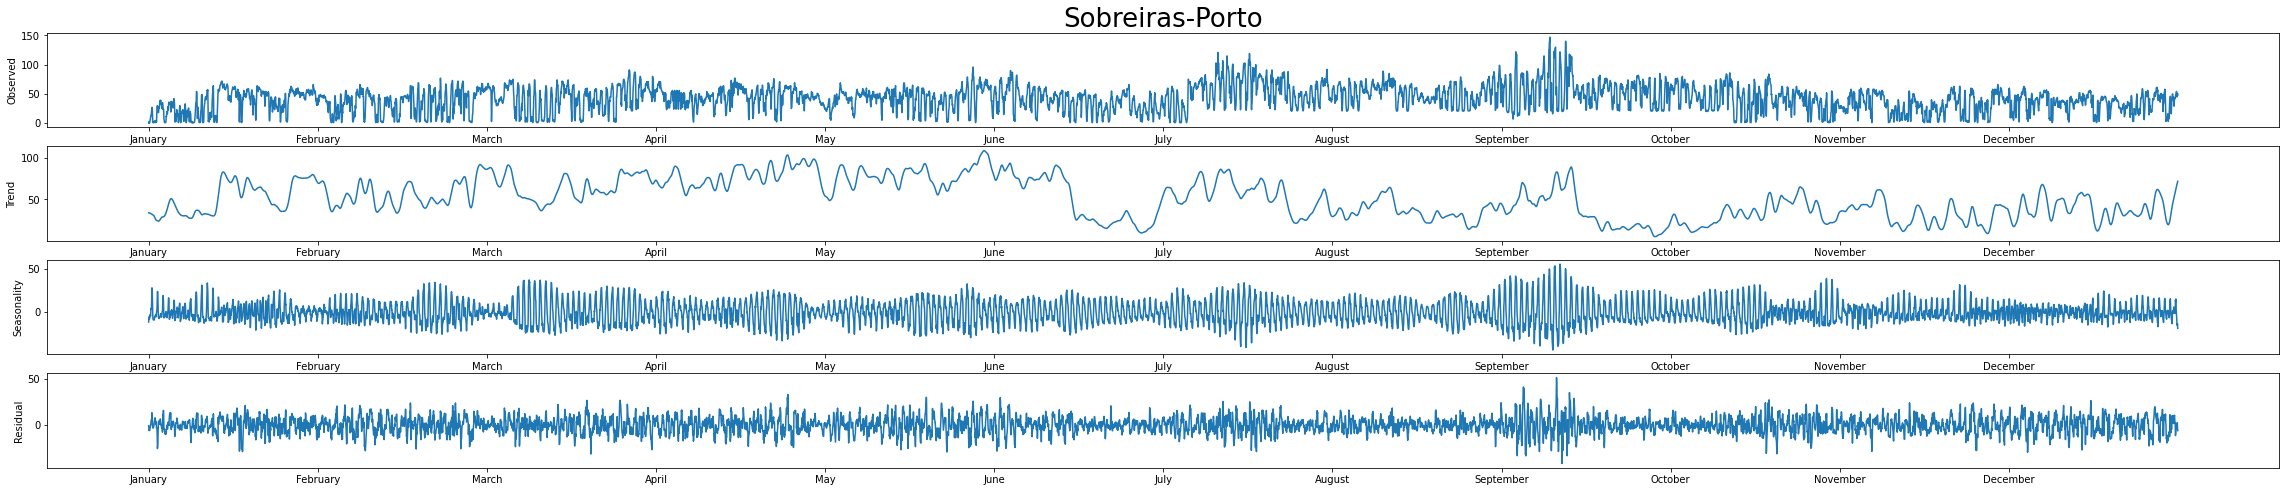

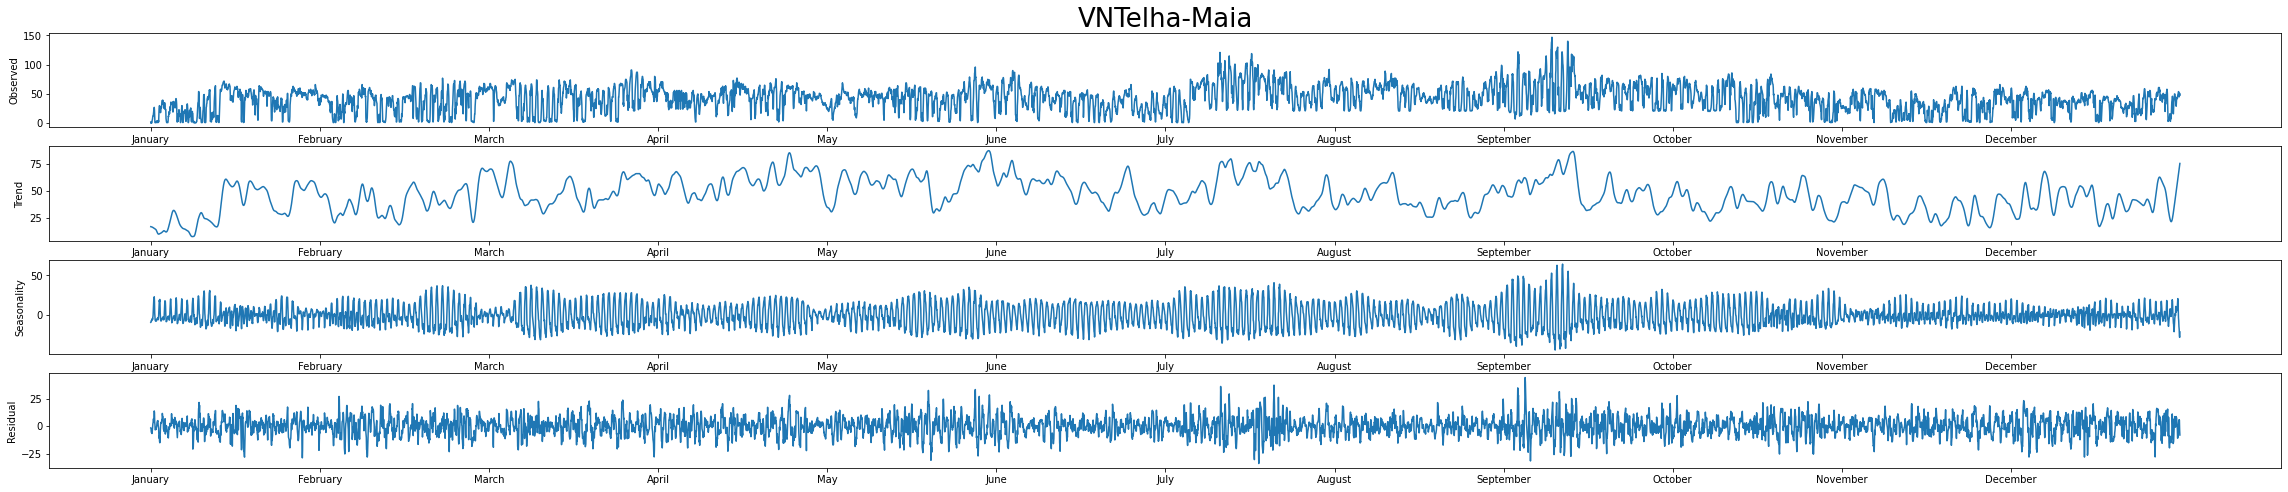

In [13]:
# from statsmodels.tsa.seasonal import STL
# result = STL(endog=series[0][int(len(current_series)/k):], period=24).fit()
# fig, (ax1,ax2,ax3,ax4) = plt.subplots(4,1, figsize=(40,8))
# n = int(len(current_series)/k)
# current_series[n:].plot(ax=ax1)
# ax1.set_ylabel('Observed')
# result.trend[n:].plot(ax=ax2)
# ax2.set_ylabel('Trend')
# result.seasonal[n:].plot(ax=ax3)
# ax3.set_ylabel('Seasonality')
# result.resid[n:].plot(ax=ax4)
k=1
for i, s in enumerate(series):
    result = STL(endog=s, period=24).fit()
    fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(40, 8))
    n = int(len(s) / k)
    current_series[:].plot(ax=ax1)
    ax1.set_title(names[i], fontsize=26)
    ax1.set_ylabel('Observed')
    result.trend[:].plot(ax=ax2)
    ax2.set_ylabel('Trend')
    result.seasonal[:].plot(ax=ax3)
    ax3.set_ylabel('Seasonality')
    result.resid[:].plot(ax=ax4)
    ax4.set_ylabel('Residual')
    for j in range(1, 5):
        eval(f"ax{j}").set_xticks([l * int(n / (12 / k)) for l in range(int(12 / k))], minor=False)
        eval(f"ax{j}").set_xticklabels(month_name[1:int(12 / k) + 1], fontdict=None, minor=False)
    #plt.savefig(f"/Users/marcelbraasch/Downloads/STL/STL_{names[i]}.png")

# ax4.set_ylabel('Residual')
# for i in range(1,5):
#     eval(f"ax{i}").set_xticks([i*int(n/(12/k)) for i in range(int(12/k))], minor=False)
#     eval(f"ax{i}").set_xticklabels(month_name[int(12/k)+1:], fontdict=None, minor=False)

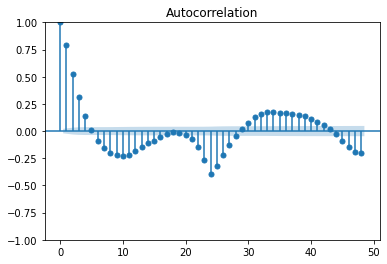

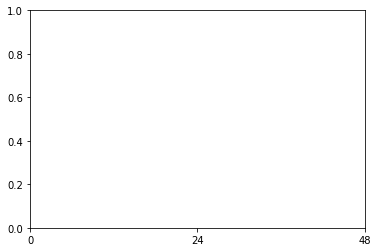

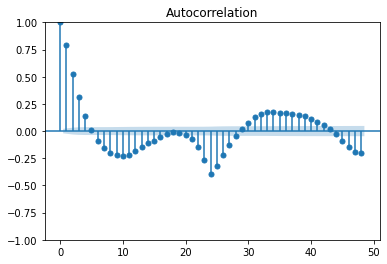

In [14]:
# Plot ACF on the residuals
d = 2
#for i, s in enumerate(series):
    #result = seasonal_decompose(s, model='a', period = 24)
s = series[0]
s = pd.Series([x+0.0001 for x in s])
#result = seasonal_decompose(s, model='a', period = 24)
result = STL(endog=s, period=24).fit()
plt.xticks([24*i for i in range(d+1)])
plot_acf(result.resid, lags=24*d)


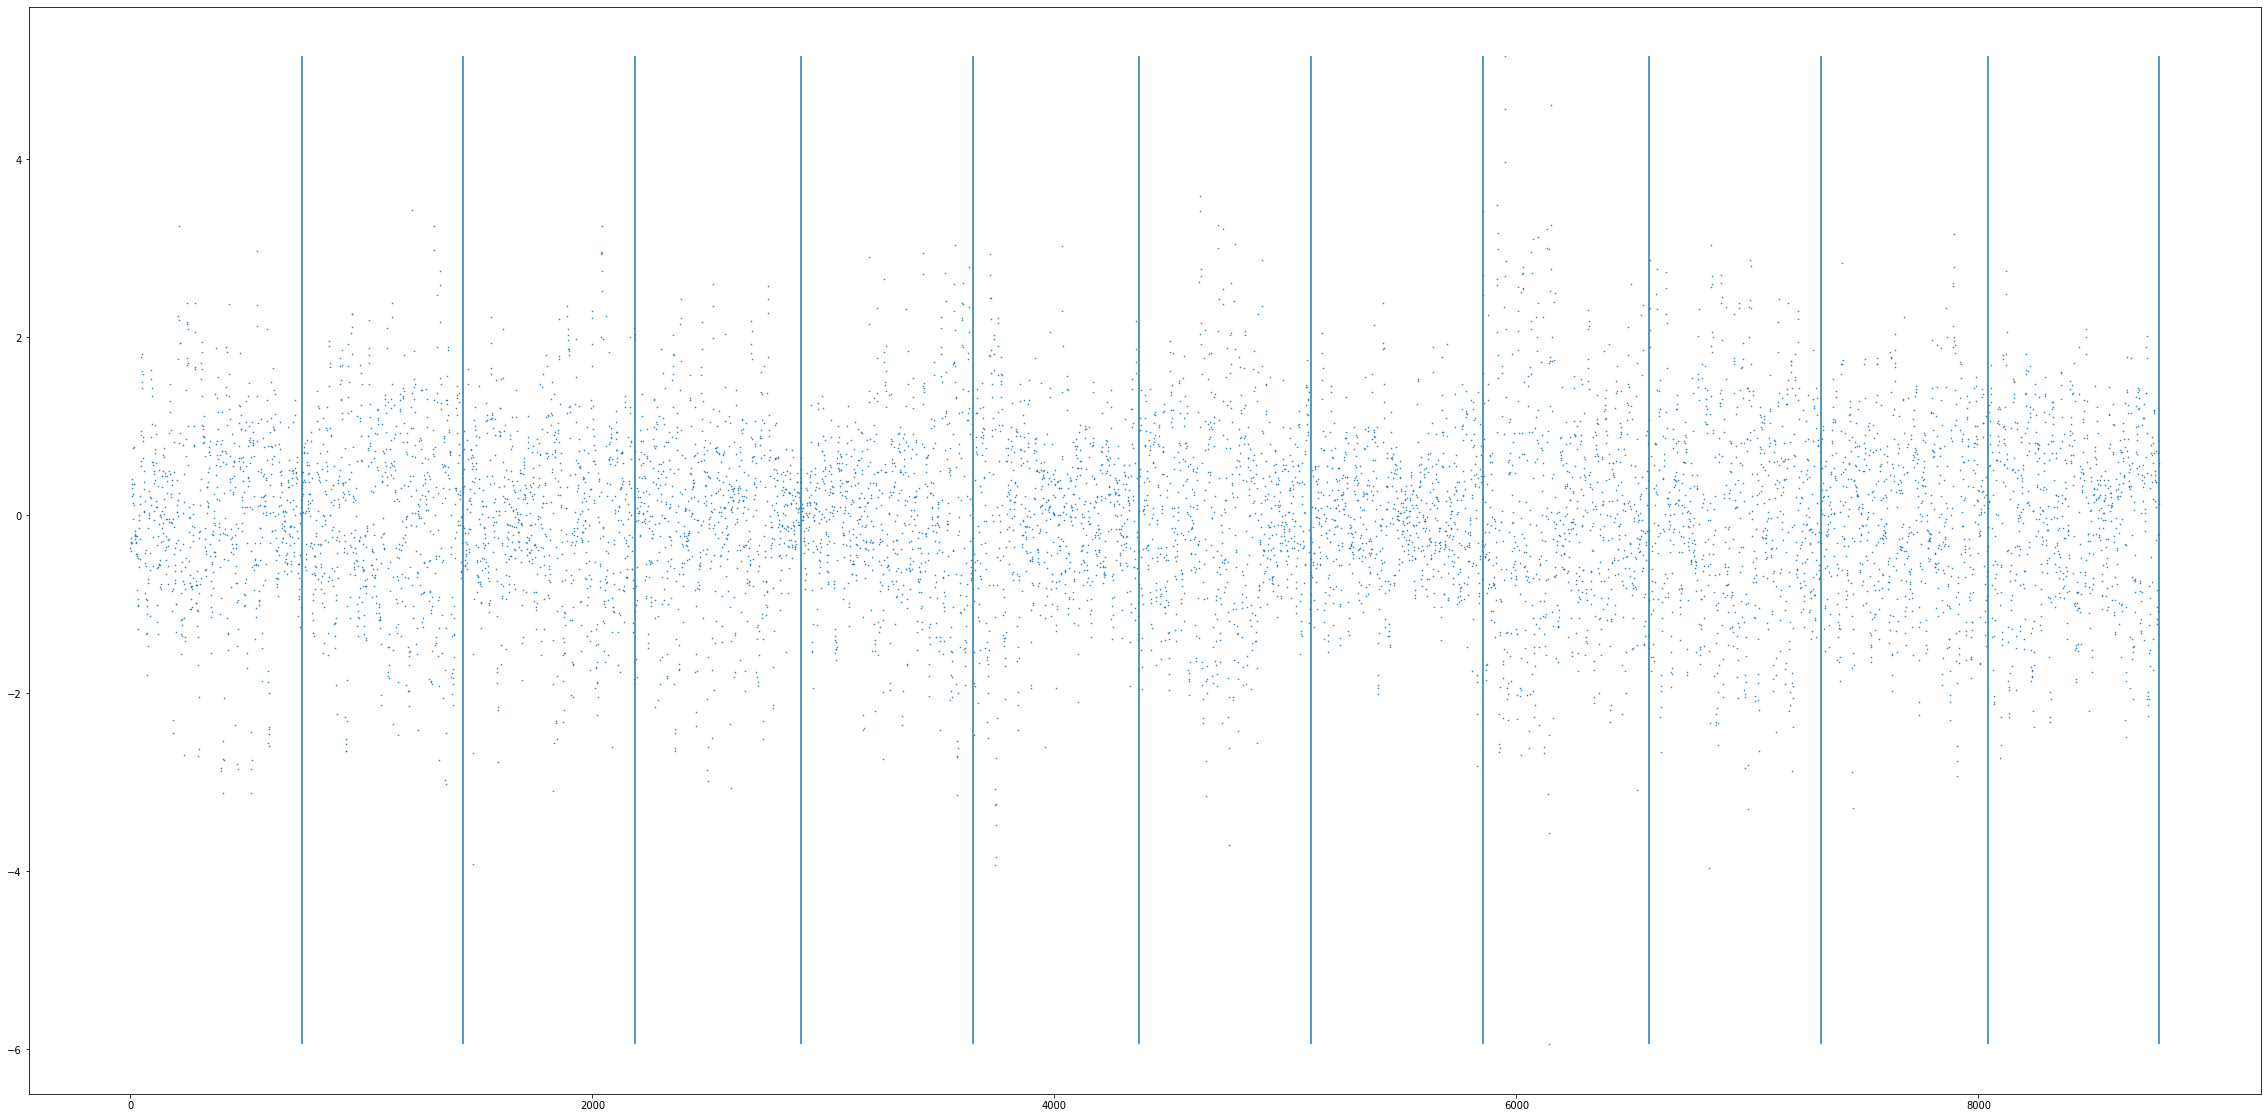

In [15]:
# (Standardized) Residual plot
residuals = result.resid.dropna()
mean, std = residuals.mean(), residuals.std()
standardized_residuals = residuals.apply(lambda x: (x-mean)/std)
fig, axs = plt.subplots(1, figsize=(40,20))
axs.scatter(x=range(len(standardized_residuals)), y=standardized_residuals, s=0.3)
axs.vlines(x=month_cuts, ymin=min(standardized_residuals), ymax=max(standardized_residuals))
#axs.text(500,200,"test")

Reject, noise follows N-distribution


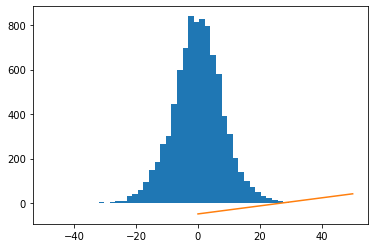

In [16]:
# Do normal test on the noise of the decomposed time series
n, bins, patches = plt.hist(residuals, 50)
plt.plot(bins)

# Normal test
alpha = 1e-3
k2, p = stats.normaltest(residuals)
result = "Reject, noise follows N-distribution" if p<alpha else "Reject, noise does not follow N-distribution"
print(result)

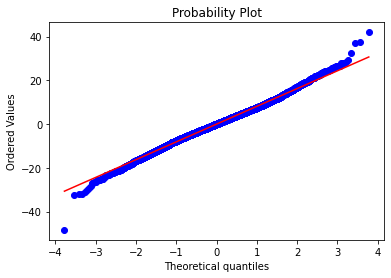

In [17]:
# QQ Plot
stats.probplot(residuals, dist="norm", plot=pylab)
pylab.show()

/home/marcelbraasch/PycharmProjects/TimeSeriesProject/venv/lib/python3.8/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


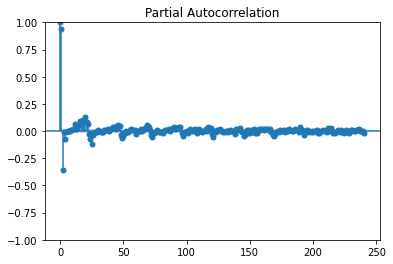

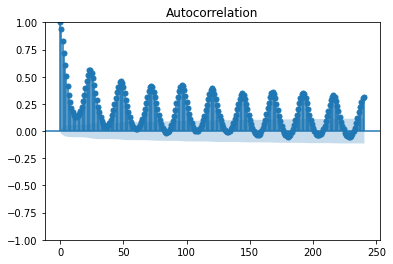

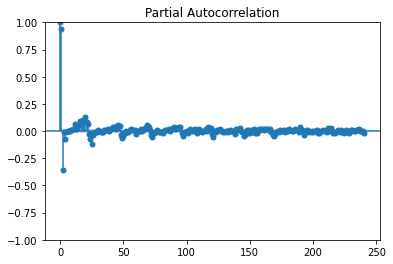

In [18]:
#ACF and PACF plots
lags = 24 * 10
plot_acf(current_series, lags=lags)
plot_pacf(current_series, lags=lags)

In [19]:
#Splitting data for evaluation
training_portion = 0.9
split = int(training_portion*len(current_series))
train, test = current_series[:split], current_series[split:]

In [ ]:
from multiprocessing import Process, Manager
import tqdm

if __name__ == "__main__":

    n = 32
    m = (24,)
    p = q = range(1,3)
    pqs = list(itertools.product(p,q))
    PQs = pqs
    configs = [(x,y) for x in pqs for y in PQs]

    def fit_model(combination, best, current_series, series_index):
        order, seasonal = combination[0]
        order_parameter = (order[0], 0, order[1])
        seasonal_parameter = (seasonal[0], 0, seasonal[1])
        key = tuple(combination)
        aic = SARIMAX(current_series, order=order_parameter, seasonal_order=seasonal_parameter+m).fit(disp=0).aic
        if series_index not in best:
            best[series_index] = []
        result = {tuple(combination):aic}
        best[series_index] += [result]

    def chunk(lst, n):
        for i in range(0, len(lst), n):
            yield lst[i:i + n]

    manager = Manager()
    best = manager.dict()

    for series_index in tqdm.notebook.tqdm(range(len(series))):
        current_series = series[series_index]
        for combinations in tqdm.notebook.tqdm(chunk(configs, n)):
            processes = []
            for combination in tqdm.notebook.tqdm(combinations):
                p = Process(target=fit_model, args=([combination], best, current_series, series_index))
                p.start()
                processes.append(p)
            for p in processes:
                p.join()
    import pickle
    with open("best_all.pkl", "wb") as f:
        pickle.dump(dict(best), f, pickle.HIGHEST_PROTOCOL)

In [25]:
# Get the predictions and residuals
m = (24,)
model = SARIMAX(current_series, order=(1,0,1), seasonal_order=(1,0,1)+m).fit()
model.resid
predictions = model.forecast(len(test))
predictions = pd.Series(predictions, index=test.index)
residuals = test - predictions
#print(predictions)

# - What is the moving average doing?
# - What is cutting and tailing off?
# -


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.36131D+00    |proj g|=  1.84765D-01

At iterate    5    f=  3.28218D+00    |proj g|=  1.38549D-02

At iterate   10    f=  3.25738D+00    |proj g|=  2.70867D-02

At iterate   15    f=  3.25373D+00    |proj g|=  2.29430D-03

At iterate   20    f=  3.25275D+00    |proj g|=  7.36480D-04

At iterate   25    f=  3.25266D+00    |proj g|=  1.94318D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     26     34      1     0     0   

       lb_stat     lb_pvalue
48  192.132326  3.825354e-19


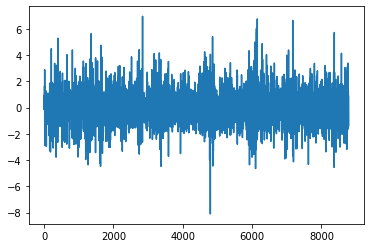

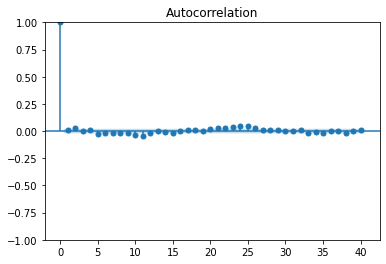

In [26]:
def standardize(x):
    return (x - mean_resid)/std_resid

residuals = model.resid

mean_resid = residuals.mean()
std_resid = residuals.std()
residuals_standard = residuals.apply(standardize)

plt.plot(residuals_standard)


#test 1
plot_acf(residuals_standard)

#test 2
print(sm.stats.acorr_ljungbox(residuals_standard, lags = [48], return_df = True)) #lags should include at least two seasonal periods

#test 3
import pickle
with open("series.pkl", "wb") as handle:
    pickle.dump(residuals_standard, handle, protocol=pickle.HIGHEST_PROTOCOL)



Text(0, 0.5, 'Error')

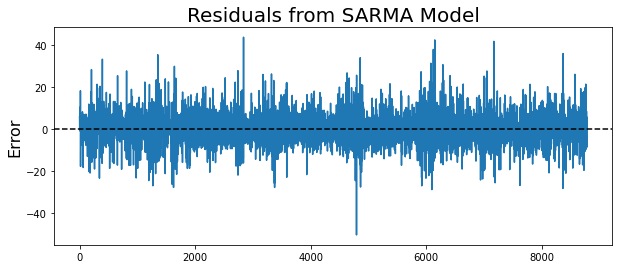

In [27]:
#Plotting residuals
plt.figure(figsize=(10,4))
plt.plot(residuals)
plt.axhline(0, linestyle='--', color='k')
plt.title('Residuals from SARMA Model', fontsize=20)
plt.ylabel('Error', fontsize=16)

KeyError: 'lower Antas-Espinho'

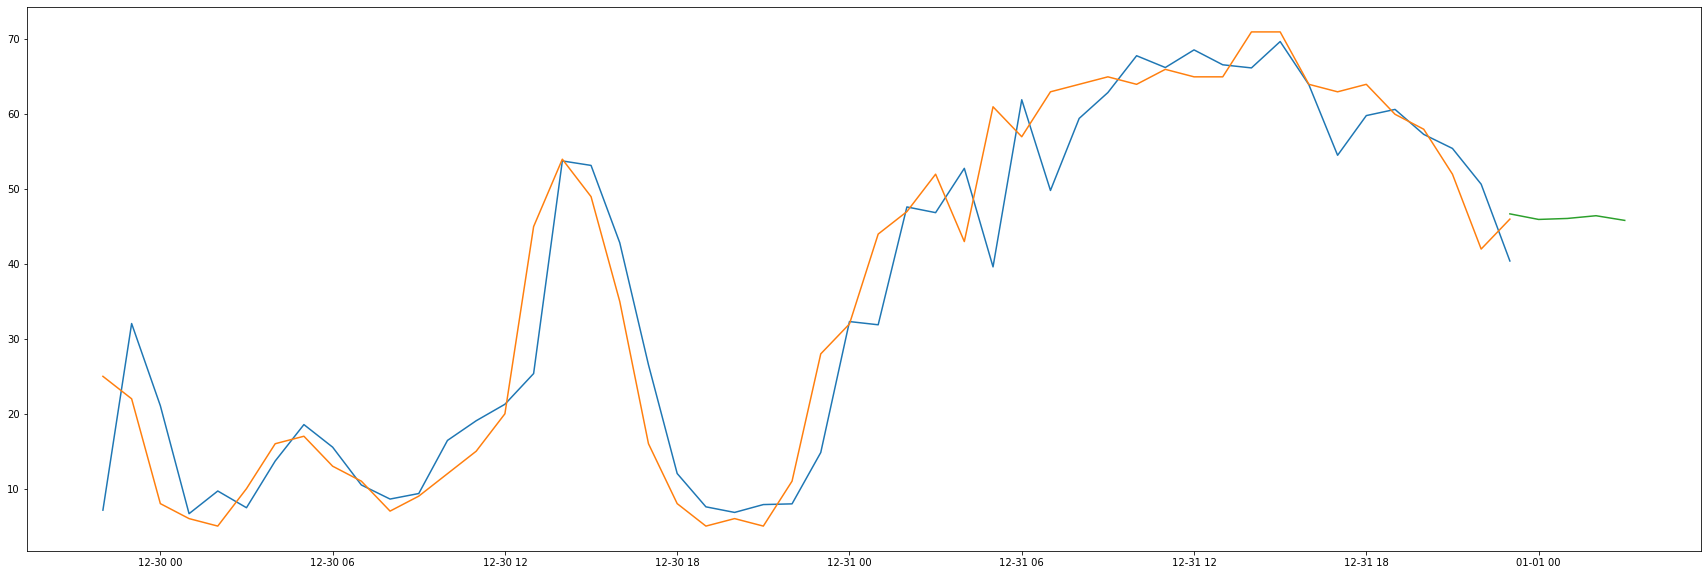

In [28]:
#FORECASTING
steps = 5
predictions = model.get_forecast(steps)
ci = predictions.conf_int()
pred = predictions.predicted_mean

#Forecast Time span
pred_time = pd.date_range(dates[-1], periods=len(pred), freq='H')

#Plotting the results
fig, axs = plt.subplots(1, figsize=(30,10))
plt_series = current_series[-50::]
plt_dates = dates[-50::]
plt_fitted = model.fittedvalues[-50::] #The predicted values of the model

plt.plot_date(plt_dates,plt_fitted, '-', label='Fitted')
plt.plot_date(plt_dates,plt_series,'-', label='Series')
plt.plot_date(pred_time, pred, '-', label='Forecasted')
plt.fill_between(pred_time, ci['lower Antas-Espinho'] , ci['upper Antas-Espinho'] , color='b', alpha=.3)

plt.legend()
plt.show()

In [29]:
# Get the predictions and residuals

predictions = model.forecast(len(test))
predictions = pd.Series(predictions, index=test.index)
residuals = test - predictions

<class 'statsmodels.tsa.statespace.sarimax.SARIMAXResultsWrapper'>
      lower VNTelha-Maia  upper VNTelha-Maia
8784           34.463659           58.934079
8785           26.896882           65.013453
8786           22.850625           69.321534
8787           20.257449           72.643111
8788           17.418783           74.234784
8784    46.698869
8785    45.955168
8786    46.086079
8787    46.450280
8788    45.826783
Name: predicted_mean, dtype: float64


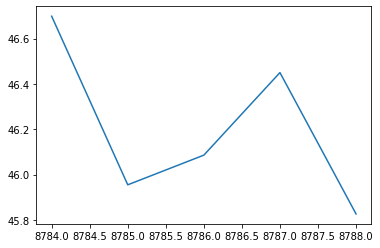

In [30]:
steps = 5
print(type(model))
predictions = model.get_forecast(steps)
print(predictions.conf_int())
print(predictions.predicted_mean)
plt.plot(predictions.predicted_mean)